In [270]:
from Preprocessing import *;
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split;
from sklearn.preprocessing import LabelEncoder, OneHotEncoder;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report;
from sklearn.feature_extraction.text import TfidfVectorizer
#from skfeature.function.similarity_based import fisher_score;
#from skfeature.function.statistical_based import gini_index;
import seaborn as sns
plt.style.use('ggplot')

In [77]:
data = train_df.reset_index(drop=True)
test = pd.read_json("test.json")

# 1. Feature Selection

Since the building_id, listing_id, and manager_id are neither categorical or numeric data, it really isn't relevant for our model. We will remove these attributes. We will also remove the photos column because we won't be using this in our model either. We will also remove street_address because we can use the display_address as a categorical value since this is just the genral street that the listing is on. This helps identify the general neighbourhood the listing is in for the buyer. The description, created, and features columns are removed because these are represented by newly extracted feature columns from the previous milestone.

In [78]:
data.drop(['photos','listing_id','building_id','manager_id','street_address','features','description','created'], axis=1, inplace=True)

## Label encode

In [79]:
data["interest_level"] = data["interest_level"].astype('category')
data["target"] = data["interest_level"].cat.codes
data.drop(['interest_level'], axis=1, inplace=True)

In [80]:
data["address"] = data["display_address"].astype('category')
data["address"] = data["address"].cat.codes
data.drop(['display_address'], axis=1, inplace=True)

## Split our data

I will split our input and target variables into X and y respectively. I do this before feature selection to reduce bias by keeping the test data untouched. In this way, the test data doesn't affect our selection methods. Next, we will check the distribution of our target variable to see if we must stratify our training and testing data samples.

In [81]:
X = data.drop(['target'], axis=1)
y = data['target']

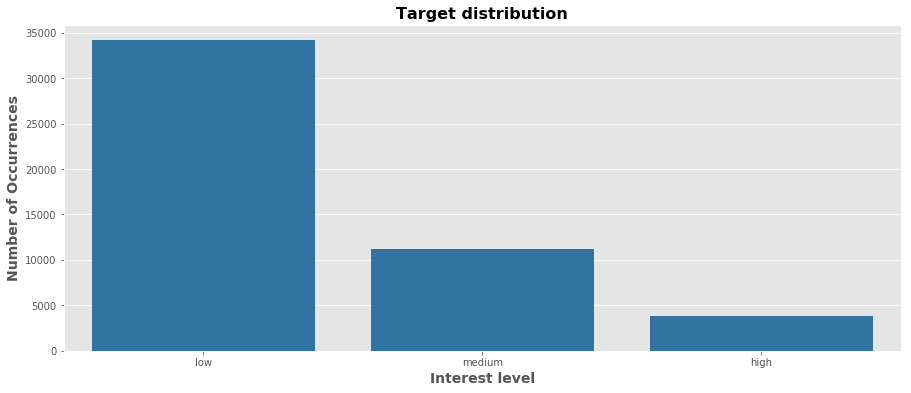

In [6]:
int_level = train_df['interest_level'].value_counts()
plt.figure(figsize=(15,6))
sns.barplot(int_level.index, int_level.values, alpha=1, order=['low','medium','high'],color=color[0])
plt.ylabel('Number of Occurrences', fontsize=14, fontweight='bold')
plt.xlabel('Interest level', fontsize=14, fontweight='bold')
plt.title('Target distribution', fontsize=16, fontweight='bold')
plt.show()

Since the distribution is skewed, we should stratify our data when spliting so it represents our data well.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)
X_train.reset_index(inplace=True);
X_test.reset_index(inplace=True);
y_train.reset_index();
y_test.reset_index();

In [98]:
kf = KFold(n_splits=5)

## Fisher score

Since this is only valid for numerica features, we must first take a subset of our data. We will separate the data based on interest level to calculate the mean and standard deviation of each class. These values will be used to calculate the fisher score for each feature. We can then use a filtering technique to find the most relevant features based on the scores. 

In [84]:
# take subset
numeric = ['bathrooms','bedrooms','latitude','longitude','price','hour_created','address']
num_data = data[['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','target']]

In [85]:
# separate data by interest level
high = num_data[num_data['target'] == 2].drop(['target'], axis=1)
med = num_data[num_data['target'] == 1].drop(['target'], axis=1)
low = num_data[num_data['target'] == 0].drop(['target'], axis=1)

In [86]:
# calculate mean of each feature in each class
avg_if = np.array([high.mean(),
      med.mean(),
      low.mean()])
#calculate mean of each feature
avg_f = np.array(num_data.drop(['target'], axis=1).mean())

In [87]:
# calculate variance for each feature
var = np.square(np.array([high.std(),
      med.std(),
      low.std()]))

# calculate probability of each class
prob = np.array([high.shape[0]/float(data.shape[0]),
             med.shape[0]/float(data.shape[0]),
             low.shape[0]/float(data.shape[0])]
)

In [88]:
fisher = []
numerator = []
denomerator = []

for feat in np.arange(0,avg_if.shape[1]):
    for class_i in np.arange(0,avg_if.shape[0]):
        numerator.append(np.array(prob[class_i]*np.square(avg_if[class_i][feat]-avg_f[feat])))
        denomerator.append(np.array(prob[class_i]*var[class_i]))      
    fisher.append(np.array(numerator).sum()/np.array(denomerator).sum())
fisher

[3.3159763636589696e-10,
 3.5701864052593236e-10,
 2.381635477575132e-10,
 1.7865112839818668e-10,
 0.001923534630954183,
 0.0016029606550212914,
 0.00274435114891092]

From the fisher scores, it looks like the address, price, and hour the listing was created have the best fisher score, in that order. The worst was longitude and the rest weren't that far off either with 10 significant digits. 

# 2. Train Classifiers

## First Version

The classifier doesn't accept the extracted text features from the previous milestone so for the first classifier they were removed and the classifier was trained for the numerical data only. The 3 features with the highest fisher scores are selected for the first classifier. These are price, hour created, and bedrooms. The default Gini index was used to determine the best split for each node. The classifier predicted with average 62.52% accuracy.

In [239]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
top3 = ['price', 'hour_created', 'address']
for train_index, valid_index in kf.split(X):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[top3]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[top3])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6225609756097561,
 0.6208333333333333,
 0.6315682488057729,
 0.6254700680963513,
 0.6253684317511943]

In [240]:
np.array(acc_scores).mean()

0.6251602115192816

## Second Version

All numeric features were used for this classifier. Gini index was used to determine the best split for each node. The classifier predicted with average 64.92% accuracy. It looks like the classifier has slightly better accuracy with all features.

In [241]:
# perform cross-validation for first set of classifiers
acc_scores = []
for train_index, valid_index in kf.split(X_train):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6463414634146342,
 0.6441819105691057,
 0.6537093495934959,
 0.6515055266166941,
 0.6501079913606912]

In [242]:
np.array(acc_scores).mean()

0.6491692483109242

## Third Version

All numeric features were used for this classifier. Gini index was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.24% accuracy, which is ever so slightly better than regular k-fold cross validation.

In [244]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6522357723577236,
 0.6526422764227642,
 0.6498983739837398,
 0.6549446081918894,
 0.6524700142305346]

In [245]:
np.array(acc_scores).mean()

0.6524382090373303

## Fourth

All numeric features were used for this classifier. Entropy was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.58% accuracy, which is ever so slightly worse than regular k-fold cross validation.

In [246]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6434959349593496,
 0.6560975609756098,
 0.6619918699186992,
 0.6596198800691128,
 0.6578572880666802]

In [247]:
np.array(acc_scores).mean()

0.6558125067978904

## Fifth Version

All numeric features were used for this classifier. Gini was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting. The classifier predicted with average 66.11% accuracy, which is ever so slightly worse than regular k-fold cross validation.

In [248]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

[0.6552845528455284,
 0.654369918699187,
 0.6634146341463415,
 0.6615509706270962,
 0.6710713559666599]

In [249]:
np.array(acc_scores).mean()

0.6611382864569626

## Hot encode features vector

The Decision Tree classifier in the sklearn sorts each feature to split the data and doesn't support features that are vectors. So to use any text features we must hot encode them. However, the description vectors are 1119 long so we will only do the features. Looking at the two text features, it seems like description might not be that helpful because there are a lot of irrelevant words/strings in most of them like 'XXX'.  

In [313]:
feat = data['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [316]:
X2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))
X2 = X[numeric].join(X2)

## Process test input

In [301]:
test = pd.read_json("test.json")
test["created"] = pd.to_datetime(test["created"])
# add hour created column
test["hour_created"] = test["created"].dt.hour

## Label encode

In [302]:
test["address"] = test["display_address"].astype('category')
test["address"] = test["address"].cat.codes

In [303]:
# convert features list to string
test['features'] = test['features'].apply(lambda x: ' '.join(x))

In [304]:
# extract features using tfidf
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', token_pattern=r'^[a-zA-Z][a-zA-Z]+',max_features=79)
vectorizer.fit(test['features'].values);
test['feat_vect'] = test['features'].apply(lambda x: vectorizer.transform([x]))

In [305]:
feat = test['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [306]:
#X2 = X[numeric].join(pd.DataFrame(np.array(feat_list).reshape(49197,79)))
test2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))

In [307]:
test = test.join(test2)

In [308]:
test.drop(['photos','listing_id','building_id','manager_id','street_address','features','description','created','display_address','feat_vect'], axis=1, inplace=True)
test

,bathrooms,bedrooms,latitude,longitude,price,hour_created,address,0,1,2,...,69,70,71,72,73,74,75,76,77,78
0,1.0,1,40.7185,-73.9865,2950,5,9506,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,40.7278,-74.0000,2850,6,9589,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,1.0,1,40.7306,-73.9890,3758,4,660,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,1.0,2,40.7109,-73.9571,3300,6,318,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100000,2.0,2,40.7650,-73.9845,4900,5,8767,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100001,3.0,3,40.7901,-73.9774,9000,6,10826,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,1.0,2,40.7730,-73.9571,2800,3,7117,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,1.0,0,40.6751,-73.9511,1900,6,9283,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,1.0,2,40.7597,-73.9929,3000,5,11128,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,1.0,0,40.7208,-73.9887,2300,3,9009,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sixth Version

All numeric features were used for this classifier. Gini was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting. The classifier predicted with average 66.11% accuracy, which is ever so slightly worse than regular k-fold cross validation.

In [320]:
X2

,bathrooms,bedrooms,latitude,longitude,price,hour_created,address,0,1,2,...,69,70,71,72,73,74,75,76,77,78
0,1.5,3,40.7145,-73.9425,3000.00,7,6530,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,40.7947,-73.9667,5465.00,12,4494,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1,40.7388,-74.0018,2850.00,3,7372,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1,40.7539,-73.9677,3275.00,2,5690,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4,40.8241,-73.9493,3350.00,1,8256,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,4,40.7429,-74.0028,3272.01,4,8336,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,2,40.8012,-73.9660,3600.00,3,8181,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,1,40.7427,-73.9957,5645.00,6,8356,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1,40.8234,-73.9457,1725.00,2,6139,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.0,4,40.7278,-73.9808,5800.00,2,3127,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [318]:
clf = DecisionTreeClassifier(criterion="entropy", random_state=0,min_samples_leaf=3)
clf = clf.fit(np.array(X2),np.array(y),check_input=False)

In [321]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X2, y):
    # split data
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print(X_train)
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc_scores.append(accuracy_score(y_valid, y_pred))
acc_scores

       bathrooms  bedrooms  latitude  longitude    price  hour_created  \
9807         1.0         0   40.7372   -73.9981  2675.00             2   
9808         1.0         0   40.7350   -74.0010  2775.00             1   
9809         1.0         0   40.7740   -73.9493  1850.00             4   
9810         1.0         1   40.7168   -73.9520  3550.00             5   
9812         1.0         1   40.7476   -74.0008  2600.00            18   
9813         1.0         1   40.7805   -73.9464  3475.00             3   
9814         1.0         1   40.7145   -73.9383  2395.00             1   
9817         1.0         3   40.6700   -73.9388  2295.00             5   
9818         1.0         2   40.6419   -73.9998  2200.00             3   
9820         2.0         3   40.8013   -73.9606  4500.00             3   
9822         1.0         1   40.6899   -73.9941  4410.00             1   
9823         1.0         0   40.7745   -73.9897  3645.00             1   
9824         1.0         1   40.7981  

ValueError: setting an array element with a sequence.

In [249]:
np.array(acc_scores).mean()

0.6611382864569626

## Confusion Matrix

In [159]:
conf_matrix = confusion_matrix(y_valid, y_pred)
conf_matrix

array([[  73,   85,   76],
       [ 108, 1807,  370],
       [ 112,  393,  200]])

In [155]:
print(classification_report(y_valid, y_pred, target_names=['low', 'medium','high']))

              precision    recall  f1-score   support

         low       0.25      0.31      0.28       234
      medium       0.79      0.79      0.79      2285
        high       0.31      0.28      0.30       705

   micro avg       0.65      0.65      0.65      3224
   macro avg       0.45      0.46      0.45      3224
weighted avg       0.65      0.65      0.65      3224



## Multi-class log loss output

In [ ]:
# Test output for log loss
y_prob = clf.predict_proba(X_test[numeric])